In [1]:
# Gute Fragestellung für datascience Projekt (Sportify)
# Gibt es einen Zusammenhang zwischen eigenen Musikgeschmack und der Geschmack der anderen?

# Importieren der benötigten Bibliotheken
import sys
import os as os
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import spotipy
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook


# Variablen und Funktionsdeklarationen

Um mit spotipy auf die Daten zugreiffen zu können, müssen `CLIENT_ID` und `CLIENT_SECRET` zwingendermassen gesetzt sein. Die Variablen `USERSANGEETHS` und `USERSTIAFEN` notwendig da wir mit der Spotipy methode `user_playlist` arbeiten.

In [2]:
CLIENT_ID = "082b3dd7a97642d49b60a647673caa75"
CLIENT_SECRET = "276e4715f8a14a34a7622c0105a8588c"
USERSANGEETHS = "qme120m1x3bg2wrtw3haiiyrb"
USERSTIAFEN = "stiafen"

client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #spotify object to access API

In [3]:
# get all playlists of a user
def get_playlists(user):
    playlists = sp.user_playlists(user)
    playlist_ids = []
    while playlists:
        for i, playlist in enumerate(playlists['items']):
            playlist_ids.append(playlist['id'])
        if playlists['next']:
            playlists = sp.next(playlists)
        else:
            playlists = None
    return playlist_ids

In [4]:
playlistsSangeeths = get_playlists(USERSANGEETHS)
playlistsTiafen = get_playlists(USERSTIAFEN)

# get the name of the playlists, will later be used to print all available playlists for a user
def get_playlist_name(user, playlist_id):
    playlist = sp.user_playlist(user, playlist_id)
    return playlist['name'], playlist['id']


In [5]:
#Funktion welche mittels user und playlist ID alle Tracks für eine Playlist ausgibt
def get_playlist_tracks(user, playlist_id):
    results = sp.user_playlist_tracks(user, playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks


In [6]:
#Funktion welche mittels user und playlist ID alle Tracks für eine Playlist ausgibt
def get_playlist_tracks_artists(user, playlist_id):
    results = sp.user_playlist_tracks(user, playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

Um nun die ID der playlist zu erhalten, in welcher wir unsere Lieblingssongs gespeichert haben nutzen wir die zuvor definierte Funktion `get_playlist_name` welche über das Resultat der Funktion `get_playlists` für den jeweiligen Benutzer läuft.
Um die Übersicht zu behalten haben wir unsere Playlists *Fav Songs "NAME"* genannt

In [7]:
for playlist in playlistsSangeeths:
    print(get_playlist_name(USERSANGEETHS, playlist))

for playlist in playlistsTiafen:
    print(get_playlist_name(USERSTIAFEN, playlist))

('Testo pur🏋🏽', '7o70luarSZS5DHoODMH51U')
('Fav Songs Sangeeths', '2E7GAf1h3F19ezc18w1NpZ')
('Tamil Vibes', '64Lq6W07GIOs087K88iOzT')
('Arabic  Vibes', '1Rr83zHLDULxQDbC9taydm')
('Albanien Vibes', '6jyy1HUool6rj0xWLVsAPC')
('UK DRILL ', '5ycwKESGY1Z71ftYWmTVJs')
('Baba Vibes', '67a5HCEjwm4aXvjPVoxoAX')
('Fav Songs Stiafen', '0ekbyk9EKkCf4MBjrQoM2D')
('Favorite Songs', '4DeCJm3aeeb0TTdthf8MGY')
('Caterpillar (feat. Eminem & King Green)', '1JKSl9B6hJNCGFs9FdOq8I')
('Meine Playlist Nr.\xa034', '3uBDJVShkGJKFxPNnjC7IL')
('Dein Mixtape\xa06 - ZUSAMMENGESTELLT FÜR STIAFEN:21.06.19', '48I13UCIzloZpyRE23zwIa')
('Mixtape 3', '2jnqcj5CxaBLHjzVafdmce')
('Oldschool', '4RjDNPzba04zlAan0a4bTE')


In [8]:
#Variablen für Playlists Sangeeths und Stiafen
favoritplaylistSangeeths = "2E7GAf1h3F19ezc18w1NpZ"
favoritplaylistStiafen = "0ekbyk9EKkCf4MBjrQoM2D"


# Für Beide User wird eine Dataframe mit allen Tracks erstellt
tracksSangeeths = get_playlist_tracks(USERSANGEETHS, favoritplaylistSangeeths)
tracksSangeeths = pd.DataFrame(tracksSangeeths)

tracksStiafen = get_playlist_tracks(USERSTIAFEN, favoritplaylistStiafen)
tracksStiafen = pd.DataFrame(tracksStiafen)

In [9]:
# just put colomn track in a new dataframe
tracksSangeeths = tracksSangeeths['track']
tracksStiafen = tracksStiafen['track']
# get all the info in colomn track
tracksSangeeths = tracksSangeeths.apply(pd.Series)
tracksStiafen = tracksStiafen.apply(pd.Series)
tracksStiafen




,album,artists,available_markets,disc_number,duration_ms,episode,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track,track_number,type,uri
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,1463703,False,False,{'isrc': 'DESR72036116'},{'spotify': 'https://open.spotify.com/track/3d...,https://api.spotify.com/v1/tracks/3ddAtoSripae...,3ddAtoSripaeASJeovlIsg,False,Symphony No. 3 in D Minor: VI. Langsam. Ruhevo...,27,https://p.scdn.co/mp3-preview/87233ea4f437e0c7...,True,6,track,spotify:track:3ddAtoSripaeASJeovlIsg
1,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,378733,False,False,{'isrc': 'DEE861700261'},{'spotify': 'https://open.spotify.com/track/1O...,https://api.spotify.com/v1/tracks/1Oo7XEqkrwif...,1Oo7XEqkrwifJn17aA0ocF,False,"Sechs Klavierstücke, Op. 118: II. Intermezzo i...",64,https://p.scdn.co/mp3-preview/34054c2ef25c45bb...,True,9,track,spotify:track:1Oo7XEqkrwifJn17aA0ocF
2,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, BB, B...",1,295218,False,False,{'isrc': 'DEN960100244'},{'spotify': 'https://open.spotify.com/track/3o...,https://api.spotify.com/v1/tracks/3o9br9LskOEb...,3o9br9LskOEbwc5irxfHqR,False,"Serenade for Strings in E Major, Op. 22, B. 52...",51,None,True,4,track,spotify:track:3o9br9LskOEbwc5irxfHqR
3,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,132120,False,False,{'isrc': 'HKI190055512'},{'spotify': 'https://open.spotify.com/track/5T...,https://api.spotify.com/v1/tracks/5TtmI9sfXw4V...,5TtmI9sfXw4VXco0PE21mV,False,"2 Aquarelles: Lento, ma non troppo",63,https://p.scdn.co/mp3-preview/53e4cd9c2b3f4a4c...,True,12,track,spotify:track:5TtmI9sfXw4VXco0PE21mV
4,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,407946,False,False,{'isrc': 'DEAD62004705'},{'spotify': 'https://open.spotify.com/track/6a...,https://api.spotify.com/v1/tracks/6aD8MeXrjHNz...,6aD8MeXrjHNz7YgrTLHhyA,False,"Serenade for Strings in E Minor, Op. 20: II. L...",39,https://p.scdn.co/mp3-preview/9638a58cd7378e33...,True,5,track,spotify:track:6aD8MeXrjHNz7YgrTLHhyA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,118200,False,False,{'isrc': 'USX761440301'},{'spotify': 'https://open.spotify.com/track/0B...,https://api.spotify.com/v1/tracks/0BgHDpDnFg1W...,0BgHDpDnFg1Wfm9r7XsWeG,False,Book I: Prelude and Fugue No. 1 in C Major BWV...,39,https://p.scdn.co/mp3-preview/8aabf7351a2e09f0...,True,1,track,spotify:track:0BgHDpDnFg1Wfm9r7XsWeG
364,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,965280,False,False,{'isrc': 'GBAYC0702035'},{'spotify': 'https://open.spotify.com/track/2J...,https://api.spotify.com/v1/tracks/2JzsHRzDT3kC...,2JzsHRzDT3kCokSu0ggZ8U,False,"Schumann: Piano Concerto in A Minor, Op. 54: I...",31,https://p.scdn.co/mp3-preview/a4ac5cbd82a3c6a8...,True,4,track,spotify:track:2JzsHRzDT3kCokSu0ggZ8U
365,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,329626,False,False,{'isrc': 'DEN961801830'},{'spotify': 'https://open.spotify.com/track/2P...,https://api.spotify.com/v1/tracks/2PD8ghbTwRy3...,2PD8ghbTwRy3tqQkXnMsjs,False,"Rêverie, L. 68",34,None,True,12,track,spotify:track:2PD8ghbTwRy3tqQk

In [10]:
#Get Audio features for all tracks in favorite Playlist

#Falls lokale Kopie der Daten existiert wird diese verwendet
if not os.path.isfile('audiofeatures_stiafen.csv'):
    genres = []
    popularity = []
    features = []
    #Extract Audio Features
    for uri in tracksStiafen['uri']:

        features = features+sp.audio_features(uri)

    audioFeaturesStiafen = pd.DataFrame(features)
    audioFeaturesStiafen['user'] = "Stiafen"

    #Extract Artistpopularity
    for artist in tracksStiafen['artists']:
        dictionary = artist[0]
        artistinfo = sp.artist(dictionary['id'])
        artistpopularity = artistinfo['popularity']
        artistgenres = artistinfo['genres']
        popularity.append(artistpopularity)
        genres.append(artistgenres)



    #Popularity anhängen und Export to csv
    tracksStiafen['artistpopularity'] = popularity
    tracksStiafen['artistgenres'] = genres
    audioFeaturesStiafen['artistpopularity'] = popularity
    audioFeaturesStiafen['artistgenres'] = genres
    tracksStiafen.to_csv('tracks_stiafen.csv')
    audioFeaturesStiafen.to_csv('audiofeatures_stiafen.csv')

else:
    audioFeaturesStiafen = pd.read_csv('audiofeatures_stiafen.csv')



if not os.path.isfile('audiofeatures_sangeeths.csv'):
    genres = []
    popularity = []
    features = []
    for uri in tracksSangeeths['uri']:
       features = features+sp.audio_features(uri)
    audioFeaturesSangeeths = pd.DataFrame(features)
    audioFeaturesSangeeths['user'] = "Sangeeths"
    audioFeaturesSangeeths.to_csv('audiofeatures_sangeeths.csv')

    for artist in tracksSangeeths['artists']:
        dictionary = artist[0]
        artistinfo = sp.artist(dictionary['id'])
        artistpopularity = artistinfo['popularity']
        artistgenre = artistinfo['genres']
        popularity.append(artistpopularity)
        genres.append(artistgenres)

    #Popularity anhängen und Export to csv
    tracksSangeeths['artistpopularity'] = popularity
    tracksSangeeths['artistgenres'] = genres
    audioFeaturesSangeeths['artistpopularity'] = popularity
    audioFeaturesSangeeths['artistgenres'] = genres
    tracksSangeeths.to_csv('tracks_sangeeths.csv')
    audioFeaturesSangeeths.to_csv('audiofeatures_sangeeths.csv')

else:
    audioFeaturesSangeeths = pd.read_csv('audiofeatures_sangeeths.csv')

#Ausgabe zur Kontrolle
#audioFeaturesSangeeths







    #Extrahiere Genres aller Artists aus einem Track und füge sie als genre Feld an das Dataframe an



 #   genresStiafen = pd.DataFrame(genres)

   # print(audioFeaturesStiafen)
    #print(genresStiafen)
    #genresStiafen.to_csv('genres_stiafen.csv')

In [11]:
audioFeaturesStiafen.corr()

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
Unnamed: 0,1.000000,0.575305,0.462658,-0.037865,0.609081,-0.147940,0.041769,-0.364316,-0.471122,0.122497,0.475403,0.175753,-0.154139,0.128971
danceability,0.575305,1.000000,0.383640,-0.104154,0.529822,-0.110256,0.148472,-0.282159,-0.355639,0.017589,0.587561,0.120819,-0.261794,0.208219
energy,0.462658,0.383640,1.000000,-0.033838,0.777419,-0.102615,0.052376,-0.723311,-0.362975,0.199139,0.734982,0.258643,-0.041682,0.124517
key,-0.037865,-0.104154,-0.033838,1.000000,-0.064427,-0.066645,0.030396,0.070111,0.012520,-0.022697,-0.044770,0.046218,-0.073367,-0.013372
loudness,0.609081,0.529822,0.777419,-0.064427,1.000000,-0.107523,0.028021,-0.540194,-0.512865,0.177102,0.607840,0.190644,-0.046795,0.127476
mode,-0.147940,-0.110256,-0.102615,-0.066645,-0.107523,1.000000,0.043247,0.053053,0.069117,0.046067,-0.116345,-0.046045,0.061714,-0.014928
speechiness,0.041769,0.148472,0.052376,0.030396,0.028021,0.043247,1.000000,-0.070255,-0.051127,0.031877,0.118490,-0.014825,-0.105523,0.012549
acousticness,-0.364316,-0.282159,-0.723311,0.070111,-0.540194,0.053053,-0.070255,1.000000,0.435069,-0.136241,-0.474150,-0.191300,0.006282,-0.101918
instrumentalness,-0.471122,-0.355639,-0.362975,0.012520,-0.512865,0.069117,-0.051127,0.435069,1.000000,-0.162207,-0.387149,-0.066049,0.178306,-0.092918
liveness,0.122497,0.017589,0.199139,-0.022697,0.177102,0.046067,0.031877,-0.136241,-0.162207,1.000000,0.120794,0.044980,0.015381,0.005329


# Visualisierungen
Da wir mit Machinelearning eine Klassifikation durchführen wollen, suchen wir bei der Visualisierung mittels Scatterplots nach möglichen Clustern.

In [12]:
#Beginn Visualisierungen
#Dataframe um mögliche Cluster zu finden
allAudioFeatures = audioFeaturesSangeeths.append(audioFeaturesStiafen)

C:\Users\csang\AppData\Local\Temp\ipykernel_32828\831092147.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allAudioFeatures = audioFeaturesSangeeths.append(audioFeaturesStiafen)


<AxesSubplot:xlabel='energy', ylabel='danceability'>

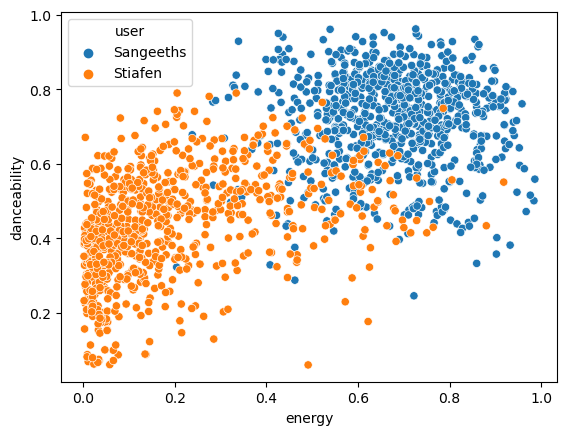

In [13]:
sns.scatterplot(data=allAudioFeatures, x="energy", y="danceability", hue="user")

<AxesSubplot:xlabel='tempo', ylabel='loudness'>

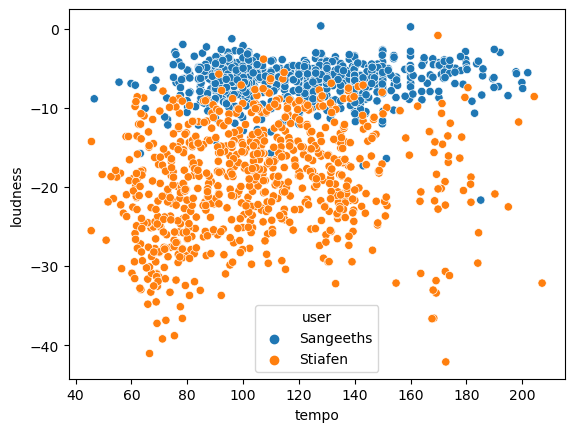

In [14]:
sns.scatterplot(data=allAudioFeatures, x="tempo", y="loudness", hue="user")

<AxesSubplot:xlabel='speechiness', ylabel='acousticness'>

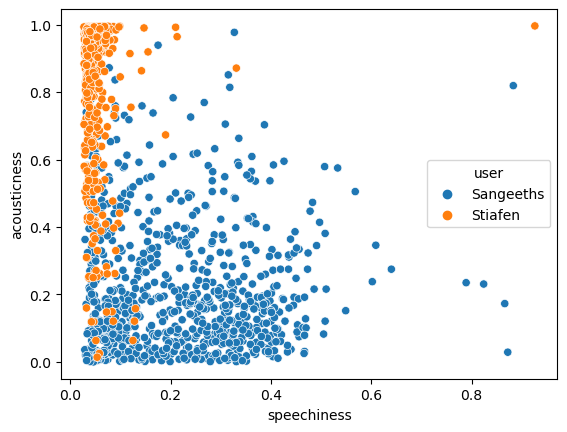

In [15]:
sns.scatterplot(data=allAudioFeatures, x="speechiness", y="acousticness", hue="user")

<AxesSubplot:xlabel='liveness', ylabel='instrumentalness'>

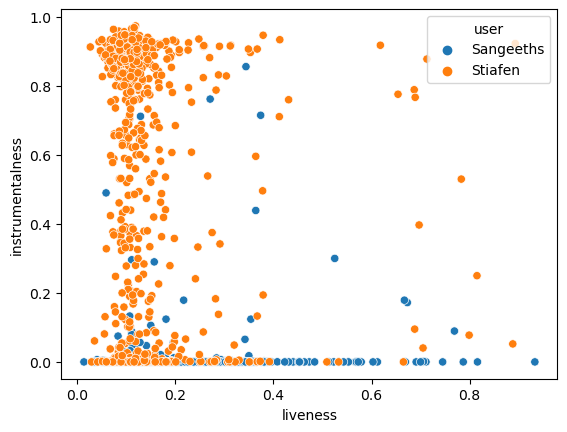

In [16]:
sns.scatterplot(data=allAudioFeatures, x="liveness", y="instrumentalness", hue="user")

<AxesSubplot:xlabel='energy', ylabel='loudness'>

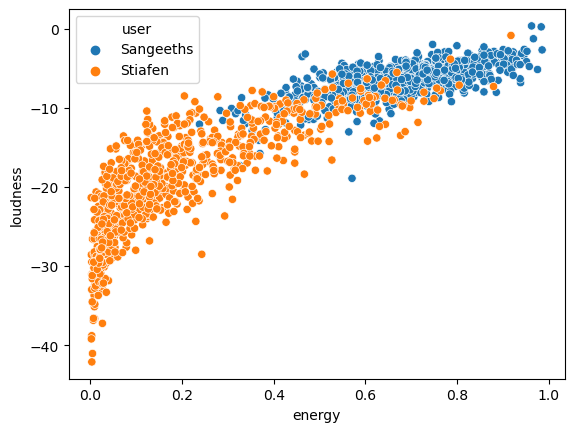

In [17]:
sns.scatterplot(data=allAudioFeatures, x="energy", y="loudness", hue="user")

<AxesSubplot:xlabel='tempo', ylabel='danceability'>

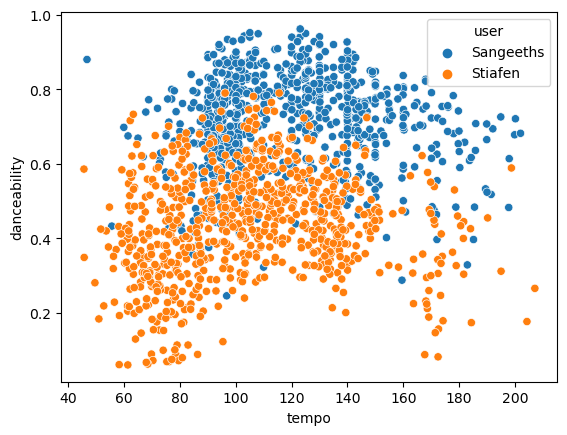

In [18]:
sns.scatterplot(data=allAudioFeatures, x="tempo", y="danceability", hue="user")

<AxesSubplot:xlabel='instrumentalness', ylabel='loudness'>

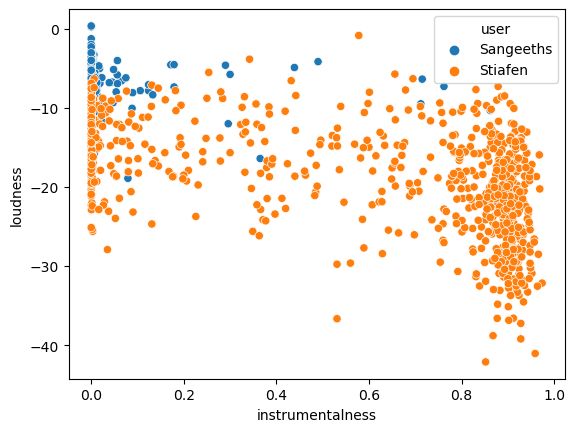

In [19]:
sns.scatterplot(data=allAudioFeatures, x="instrumentalness", y="loudness", hue="user")

<AxesSubplot:xlabel='liveness', ylabel='loudness'>

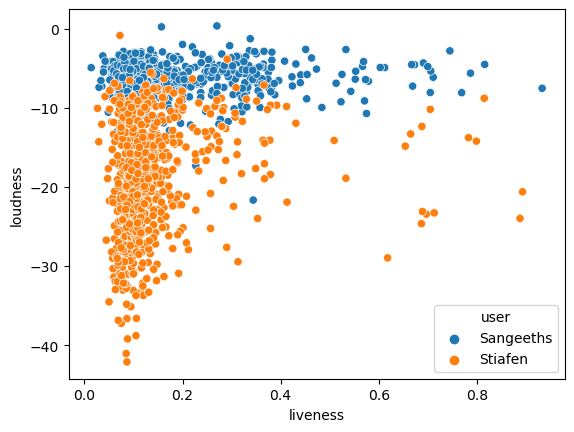

In [20]:
sns.scatterplot(data=allAudioFeatures, x="liveness", y="loudness", hue="user")

<AxesSubplot:xlabel='instrumentalness', ylabel='speechiness'>

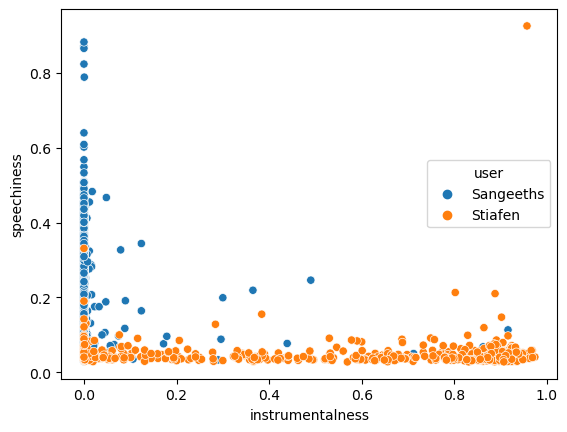

In [21]:
sns.scatterplot(data=allAudioFeatures, x="instrumentalness", y="speechiness", hue="user")

<AxesSubplot:xlabel='loudness', ylabel='danceability'>

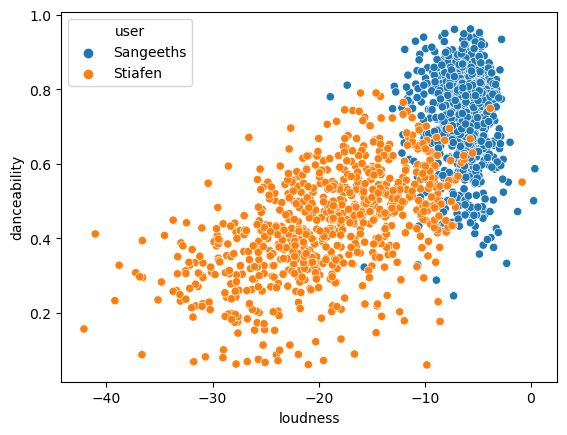

In [22]:
sns.scatterplot(data=allAudioFeatures, x="loudness", y="danceability", hue="user")

<AxesSubplot:xlabel='energy', ylabel='speechiness'>

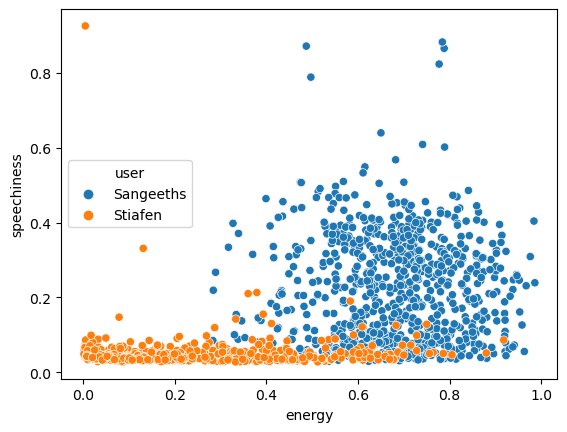

In [23]:
sns.scatterplot(data=allAudioFeatures, x="energy", y="speechiness", hue="user")

C:\Users\csang\AppData\Local\Temp\ipykernel_32828\154138562.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(K):


  0%|          | 0/9 [00:00<?, ?it/s]

c:\Users\csang\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\csang\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\csang\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\csang\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Window

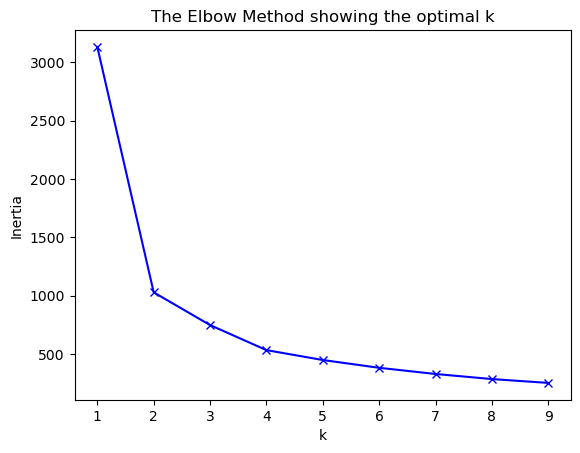

In [24]:



X = allAudioFeatures[['energy','danceability']]

scaler =  StandardScaler()
X_scaled = scaler.fit_transform(X)
inertias = []
K = range(1,10)
for k in tqdm_notebook(K):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_scaled)
    inertias.append(kmeanModel.inertia_)
    
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')

plt.plot(K, inertias, 'bx-')

c:\Users\csang\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\csang\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\csang\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\csang\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Window

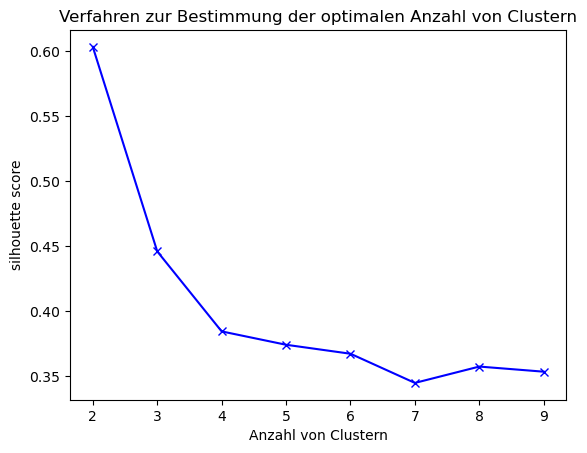

In [25]:

# Merkmale aus der Tabelle auswählen
X = allAudioFeatures[['energy','danceability']].values

# Liste der Anzahl von Clustern erstellen
k_values = range(2, 10)

# Leere Liste für silhouette scores erstellen
scores = []

# Schleife über die Anzahl von Clustern
for k in k_values:
  # K-Means-Modell erstellen
  model = KMeans(n_clusters=k)
  # Modell an die Daten anpassen
  model.fit(X)
  # silhouette score für das Modell berechnen
  score = silhouette_score(X, model.labels_)
  scores.append(score)

# Plot der silhouette scores gegenüber der Anzahl von Clustern erstellen
plt.plot(k_values, scores, 'bx-')
plt.xlabel('Anzahl von Clustern')
plt.ylabel('silhouette score')
plt.title('Verfahren zur Bestimmung der optimalen Anzahl von Clustern')
plt.show()

c:\Users\csang\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


<AxesSubplot:xlabel='energy', ylabel='danceability'>

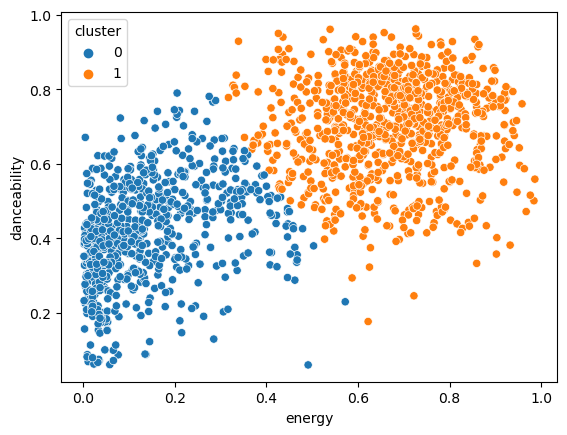

In [26]:
from sklearn.cluster import KMeans

# take the highest value of the silhouette score
kmeans = KMeans(n_clusters=2)
kmeans.fit(allAudioFeatures[['energy', 'danceability']])
allAudioFeatures['cluster'] = kmeans.labels_

sns.scatterplot(data=allAudioFeatures, x="energy", y="danceability", hue="cluster")